# Create wet snow RMSE netcdfs

Last updated: September 7, 2023

This notebook produces netcdfs that contain RMSE data per each run with different wet snow parameters.

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters

from dask.distributed import Client


In [9]:
client = Client(local_directory='/tmp', processes=False)
client

/home/eric/miniconda3/envs/spicy_snow_env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46799 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.29.231.250:46799/status,
Dashboard: http://172.29.231.250:46799/status,Workers: 1
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: False
Comm: inproc://172.29.231.250/26237/9,Workers: 1
Dashboard: http://172.29.231.250:46799/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: inproc://172.29.231.250/26237/12,Total threads: 16
Dashboard: http://172.29.231.250:41207/status,Memory: 15.49 GiB
Nanny: None,


## Loop through all sites, and for each site try process using different wet snow thresholds, freeze snow thresholds, and whether the negative SI alternate wet snow flag is activated.

In [11]:
files = sorted(glob('spicy_s1_stacks/*.nc'))

# Create parameter space
a = 2.5
b = 0.2
c = 0.55

wet_snow_thresh = np.arange(-3, -0.9, 0.1)
freeze_snow_thresh = np.arange(1, 3.1, 0.1)
#freeze_snow_thresh = np.arange(0.5, 2.1, 0.1)
SI_thresh = [0,-100]

total_count = len(wet_snow_thresh)*len(freeze_snow_thresh)*len(SI_thresh)

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')

    if Path(f'rmse_test_wet_snow/{ds_name}_wet_flag.nc').is_file():
        print('This file already exists, continuing.')
        continue

    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]

    if 'Frasier_2020-02-11' in ds_name:
        closest_ts = '2020-02-16T13:09:43.000000000'
    
    # Initialize RMSE arrays
    rmse_wet_flag = xr.DataArray(np.empty((len(SI_thresh),len(wet_snow_thresh), len(freeze_snow_thresh)))*np.nan,
                        coords=(SI_thresh,wet_snow_thresh,freeze_snow_thresh), dims=('SI_thresh','wet_snow_thresh','freeze_snow_thresh'))
    rmse_no_flag = xr.DataArray(np.empty((len(SI_thresh),len(wet_snow_thresh), len(freeze_snow_thresh)))*np.nan,
                        coords=(SI_thresh,wet_snow_thresh,freeze_snow_thresh), dims=('SI_thresh','wet_snow_thresh','freeze_snow_thresh'))
    valid_pixels = xr.DataArray(np.empty((len(SI_thresh),len(wet_snow_thresh), len(freeze_snow_thresh)))*np.nan,
                        coords=(SI_thresh,wet_snow_thresh,freeze_snow_thresh), dims=('SI_thresh','wet_snow_thresh','freeze_snow_thresh'))
    # Brute-force loop
    for wst in wet_snow_thresh:
        for fst in freeze_snow_thresh:
            for sit in SI_thresh:
                print(f'sit={sit:0.2f}, wst={wst:0.2f}; fst={fst:0.2f}')

                ds = retrieval_from_parameters(dataset,A=a,B=b,C=c,wet_SI_thresh=sit,freezing_snow_thresh=fst,wet_snow_thresh=wst)

                mask_wet = ~(ds['lidar-sd'].isnull() | ds['snow_depth'].sel(time=closest_ts).isnull() | ds['wet_snow'].sel(time=closest_ts).astype(bool))
                diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
                rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
                print(f'RMSE with wet snow masked out = {rmse_wet:0.2f}')
                rmse_wet_flag.loc[sit,wst,fst] = rmse_wet
                # Compare snow depths - no wet snow mask
                mask = ~(ds['lidar-sd'].isnull() | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
                diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
                rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
                print(f'Full RMSE = {rmse:0.2f}')
                rmse_no_flag.loc[sit,wst,fst] = rmse
                valid_pixels.loc[sit,wst,fst] = mask_wet.sum() / mask.sum()
                print(f'Frac valid pixels = {mask_wet.sum()/ mask.sum():0.2f}')


    # After loop, save RMSE results per file
    rmse_wet_flag.to_netcdf(f'rmse_test_wet_snow/{ds_name}_wet_flag.nc')
    rmse_no_flag.to_netcdf(f'rmse_test_wet_snow/{ds_name}_no_flag.nc')
    valid_pixels.to_netcdf(f'rmse_test_wet_snow/{ds_name}_valid_pixels.nc')
    

2023-09-07 09:09:35.559031  -- starting Banner_2020-02-18
This file already exists, continuing.
2023-09-07 09:09:35.559175  -- starting Banner_2021-03-15
sit=0.00, wst=-3.00; fst=0.50
RMSE with wet snow masked out = 0.87
Full RMSE = 1.02
Frac valid pixels = 0.76
sit=-100.00, wst=-3.00; fst=0.50
RMSE with wet snow masked out = 0.88
Full RMSE = 1.02
Frac valid pixels = 0.78
sit=0.00, wst=-3.00; fst=0.60
RMSE with wet snow masked out = 0.87
Full RMSE = 1.02
Frac valid pixels = 0.75
sit=-100.00, wst=-3.00; fst=0.60
RMSE with wet snow masked out = 0.88
Full RMSE = 1.02
Frac valid pixels = 0.78
sit=0.00, wst=-3.00; fst=0.70
RMSE with wet snow masked out = 0.87
Full RMSE = 1.02
Frac valid pixels = 0.72
sit=-100.00, wst=-3.00; fst=0.70
RMSE with wet snow masked out = 0.88
Full RMSE = 1.02
Frac valid pixels = 0.78
sit=0.00, wst=-3.00; fst=0.80
RMSE with wet snow masked out = 0.86
Full RMSE = 1.02
Frac valid pixels = 0.70
sit=-100.00, wst=-3.00; fst=0.80
RMSE with wet snow masked out = 0.87
Full

## Let's make sure the netcdfs are outputting correctly

In [4]:
directory = 'rmse_test_wet_snow'


which_site = 0

results1 = sorted(glob(f'{directory}/*wet*.nc'))
results2 = sorted(glob(f'{directory}/*no*.nc'))
results3 = sorted(glob(f'{directory}/*valid*.nc'))

wet_snow = xr.open_dataarray(results1[which_site])
all_snow = xr.open_dataarray(results2[which_site])
frac_valid = xr.open_dataarray(results3[which_site])

all_rmse = xr.concat([wet_snow,all_snow],'wet_or_all')



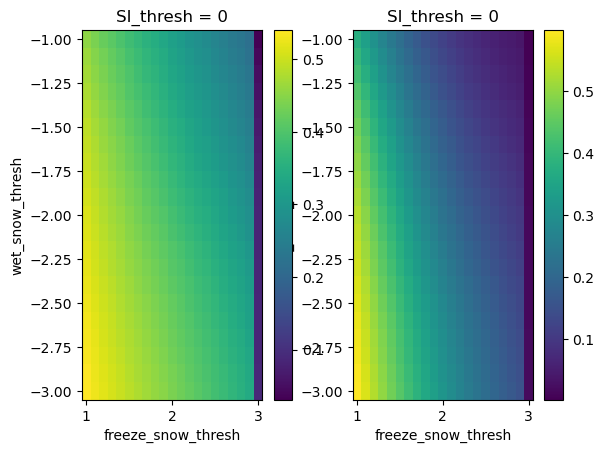

In [5]:
f,ax=plt.subplots(1,2)
wet_snow.sel(SI_thresh=0).plot(ax=ax[0])
frac_valid.sel(SI_thresh=0).plot(ax=ax[1])